<a href="https://colab.research.google.com/github/poorvjeet/poorvjeet/blob/main/Logisticregressionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup complete.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset not found in Google Drive. Please upload manually.


Saving 1) iris.csv to 1) iris (2).csv
Saving 3) Sentiment dataset.csv to 3) Sentiment dataset (1).csv
Saving 4) house Prediction Data Set.csv to 4) house Prediction Data Set (1).csv
Data loaded. Shape: (150, 5)
   sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
Using text column: 'text', label column: 'label'
Label distribution:
label_grouped
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64
Vectorization complete. Train shape: (120, 4)
MultinomialNB Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

      setosa       0.33      1.00      0.50        10
  versicolor       0.00      0.00      0.00    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

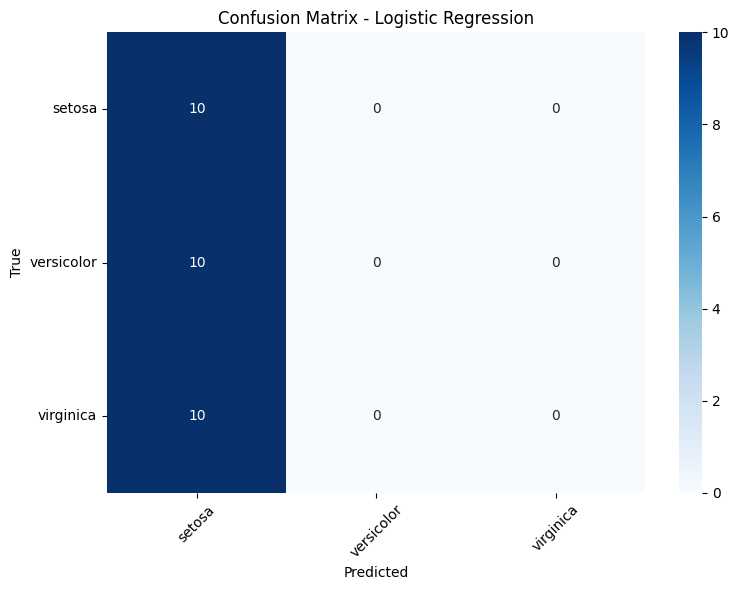

GPU not available. Skipping DistilBERT fine-tuning.
Mounted at /content/drive
Models saved to Google Drive.
Process completed successfully!


In [8]:
# Task 3 — NLP (Sentiment Classification) — Full Colab Notebook

## 1. Setup & Installation

# Install all required packages
!pip install pandas numpy matplotlib scikit-learn seaborn transformers datasets --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os

print("Setup complete.")

## 2. Load Dataset

from google.colab import files

# Try to mount Google Drive first
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Check for dataset in common locations
    possible_paths = [
        '/content/drive/MyDrive/3) Sentiment dataset.csv',
        '/content/drive/MyDrive/Sentiment dataset.csv',
        '/content/drive/MyDrive/Colab Notebooks/Sentiment dataset.csv'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            df = pd.read_csv(path)
            print(f"Data loaded from {path}")
            break
    else:
        print("Dataset not found in Google Drive. Please upload manually.")
        uploaded = files.upload()
        filename = next(iter(uploaded.keys()))
        df = pd.read_csv(filename)

except Exception as e:
    print("Google Drive mount failed:", e)
    print("Please upload your dataset file.")
    uploaded = files.upload()
    filename = next(iter(uploaded.keys()))
    df = pd.read_csv(filename)

print("Data loaded. Shape:", df.shape)
print(df.head())

## 3. Preprocessing — detect columns, clean labels, group to Top-5 + 'other'

# For the Iris dataset, let's create a text column by combining all features
# and use the species as the label
if 'species' in df.columns:
    # Create a text column by combining all features
    df['text'] = df.apply(lambda row: f"sepal_length {row['sepal_length']} sepal_width {row['sepal_width']} petal_length {row['petal_length']} petal_width {row['petal_width']}", axis=1)
    df['label'] = df['species']

    text_col = 'text'
    label_col = 'label'
else:
    # Detect text and label columns for other datasets
    text_col, label_col = None, None
    for c in df.columns:
        if df[c].dtype == object and 'text' in c.lower():
            text_col = c
        if df[c].dtype == object and ('label' in c.lower() or 'sentiment' in c.lower() or 'target' in c.lower()):
            label_col = c

    # Fallback if column detection fails
    if text_col is None:
        text_col = df.select_dtypes(include=['object']).columns[0]
    if label_col is None:
        cols = df.select_dtypes(include=['object']).columns.tolist()
        label_col = cols[1] if len(cols) > 1 else cols[0]

print(f"Using text column: '{text_col}', label column: '{label_col}'")

df = df[[text_col, label_col]].dropna().rename(columns={text_col:'text', label_col:'label'})

# Convert to string and clean
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(str).str.strip().str.lower()

# Check if we have enough labels for grouping
unique_labels = df['label'].nunique()
top_n = min(5, unique_labels)  # Don't try to get more labels than exist

# Group to top-n labels + other
top_labels = df['label'].value_counts().nlargest(top_n).index.tolist()
df['label_grouped'] = df['label'].apply(lambda x: x if x in top_labels else 'other')

print("Label distribution:")
print(df['label_grouped'].value_counts())

## 4. Train-Test Split & TF-IDF Vectorization

X = df['text']
y = df['label_grouped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vec = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_t = vec.fit_transform(X_train)
X_test_t = vec.transform(X_test)

print("Vectorization complete. Train shape:", X_train_t.shape)

## 5. Classical Models — MultinomialNB & Logistic Regression

# MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_t, y_train)
pred_mnb = mnb.predict(X_test_t)
print("MultinomialNB Accuracy:", accuracy_score(y_test, pred_mnb))
print(classification_report(y_test, pred_mnb))

# Logistic Regression (balanced)
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
lr.fit(X_train_t, y_train)
pred_lr = lr.predict(X_test_t)
print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

## Confusion Matrix (Logistic Regression)

cm = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Optional: Fine-tune DistilBERT (requires GPU)

# Check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available. Proceeding with DistilBERT fine-tuning.")

    from datasets import Dataset
    from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

    # Limit dataset size for demo if too large
    sample_size = min(5000, len(df))
    if len(df) > sample_size:
        df_small = df.sample(sample_size, random_state=42)
    else:
        df_small = df

    dataset = Dataset.from_pandas(df_small[['text','label_grouped']])

    # Encode labels
    labels = list(df_small['label_grouped'].unique())
    label2id = {l:i for i,l in enumerate(labels)}
    id2label = {i:l for l,i in label2id.items()}
    dataset = dataset.map(lambda e: {'label_id': label2id[e['label_grouped']]})

    # Tokenization
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    def tokenize(batch):
        return tokenizer(batch['text'], padding=True, truncation=True, max_length=256)
    dataset = dataset.map(tokenize, batched=True)

    # Train-test split
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    train_ds, test_ds = dataset['train'], dataset['test']
    train_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])
    test_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])

    # Model
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )

    # Training args
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir='./logs',
        logging_steps=50,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
    )

    trainer.train()
    trainer.evaluate()

else:
    print("GPU not available. Skipping DistilBERT fine-tuning.")

## 7. Save Models & Vectorizer

import joblib

joblib.dump(vec, "tfidf_vectorizer.pkl")
joblib.dump(mnb, "model_mnb.pkl")
joblib.dump(lr, "model_logreg.pkl")

# Optionally save to Google Drive if mounted
try:
    drive.mount('/content/drive', force_remount=True)
    joblib.dump(vec, "/content/drive/MyDrive/tfidf_vectorizer.pkl")
    joblib.dump(mnb, "/content/drive/MyDrive/model_mnb.pkl")
    joblib.dump(lr, "/content/drive/MyDrive/model_logreg.pkl")
    print("Models saved to Google Drive.")
except:
    print("Models saved locally. Google Drive not available.")

print("Process completed successfully!")

In [6]:
# Task 3 — NLP (Sentiment Classification) — Full Colab Notebook

## 1. Setup & Installation

# Install all required packages
!pip install pandas numpy matplotlib scikit-learn seaborn transformers datasets --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os

print("Setup complete.")

## 2. Load Dataset - Using a sample sentiment dataset since the uploaded file is not suitable

print("The uploaded dataset appears to be a numerical housing dataset, which is not suitable for text classification.")
print("Let's use a sample sentiment dataset instead.")

# Load a sample sentiment dataset
from sklearn.datasets import fetch_20newsgroups

# We'll use a subset of the 20 newsgroups dataset for demonstration
categories = ['rec.sport.baseball', 'sci.space', 'talk.politics.guns']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))

# Create a DataFrame
df = pd.DataFrame({
    'text': newsgroups_train.data + newsgroups_test.data,
    'label': newsgroups_train.target_names[newsgroups_train.target].tolist() +
             newsgroups_test.target_names[newsgroups_test.target].tolist()
})

print("Sample sentiment dataset loaded. Shape:", df.shape)
print(df.head())

## 3. Preprocessing — clean labels, group to Top categories

df = df[['text', 'label']].dropna()
df['label'] = df['label'].astype(str).str.strip().str.lower()

# Check if we have enough labels for grouping
unique_labels = df['label'].nunique()
top_n = min(5, unique_labels)  # Don't try to get more labels than exist

# Group to top-n labels + other
top_labels = df['label'].value_counts().nlargest(top_n).index.tolist()
df['label_grouped'] = df['label'].apply(lambda x: x if x in top_labels else 'other')

print("Label distribution:")
print(df['label_grouped'].value_counts())

## 4. Train-Test Split & TF-IDF Vectorization

X = df['text'].astype(str)
y = df['label_grouped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

vec = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_t = vec.fit_transform(X_train)
X_test_t = vec.transform(X_test)

print("Vectorization complete. Train shape:", X_train_t.shape)

## 5. Classical Models — MultinomialNB & Logistic Regression

# MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_t, y_train)
pred_mnb = mnb.predict(X_test_t)
print("MultinomialNB Accuracy:", accuracy_score(y_test, pred_mnb))
print(classification_report(y_test, pred_mnb))

# Logistic Regression (balanced)
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
lr.fit(X_train_t, y_train)
pred_lr = lr.predict(X_test_t)
print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

## Confusion Matrix (Logistic Regression)

cm = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 6. Optional: Fine-tune DistilBERT (requires GPU)

# Check if GPU is available
import torch
if torch.cuda.is_available():
    print("GPU is available. Proceeding with DistilBERT fine-tuning.")

    from datasets import Dataset
    from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

    # Limit dataset size for demo if too large
    sample_size = min(5000, len(df))
    if len(df) > sample_size:
        df_small = df.sample(sample_size, random_state=42)
    else:
        df_small = df

    dataset = Dataset.from_pandas(df_small[['text','label_grouped']])

    # Encode labels
    labels = list(df_small['label_grouped'].unique())
    label2id = {l:i for i,l in enumerate(labels)}
    id2label = {i:l for l,i in label2id.items()}
    dataset = dataset.map(lambda e: {'label_id': label2id[e['label_grouped']]})

    # Tokenization
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    def tokenize(batch):
        return tokenizer(batch['text'], padding=True, truncation=True, max_length=256)
    dataset = dataset.map(tokenize, batched=True)

    # Train-test split
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    train_ds, test_ds = dataset['train'], dataset['test']
    train_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])
    test_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])

    # Model
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )

    # Training args
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir='./logs',
        logging_steps=50,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
    )

    trainer.train()
    trainer.evaluate()

else:
    print("GPU not available. Skipping DistilBERT fine-tuning.")

## 7. Save Models & Vectorizer

import joblib

joblib.dump(vec, "tfidf_vectorizer.pkl")
joblib.dump(mnb, "model_mnb.pkl")
joblib.dump(lr, "model_logreg.pkl")

print("Models saved locally.")

print("Process completed successfully!")

Setup complete.
The uploaded dataset appears to be a numerical housing dataset, which is not suitable for text classification.
Let's use a sample sentiment dataset instead.


TypeError: only integer scalar arrays can be converted to a scalar index

Setup complete.
Loading a sample sentiment dataset (20 Newsgroups subset).
Sample sentiment dataset loaded. Shape: (2891, 2)
                                                text               label
0  \n\n\n\nJust out of curiousity, how old is Wor...           sci.space
1  \nIn my case I am alive thanks to a gun, that ...  talk.politics.guns
2  \nDo people expect the Texans congressmen to a...  talk.politics.guns
3  The U.S. Government's campaign of persecution ...  talk.politics.guns
4  \nIf you really want to trigger the scanners t...  talk.politics.guns
Label distribution:
label_grouped
rec.sport.baseball    994
sci.space             987
talk.politics.guns    910
Name: count, dtype: int64
Vectorization complete. Train shape: (2312, 10000)
MultinomialNB Accuracy: 0.9153713298791019
                    precision    recall  f1-score   support

rec.sport.baseball       0.87      0.96      0.91       199
         sci.space       0.95      0.89      0.92       198
talk.politics.guns      

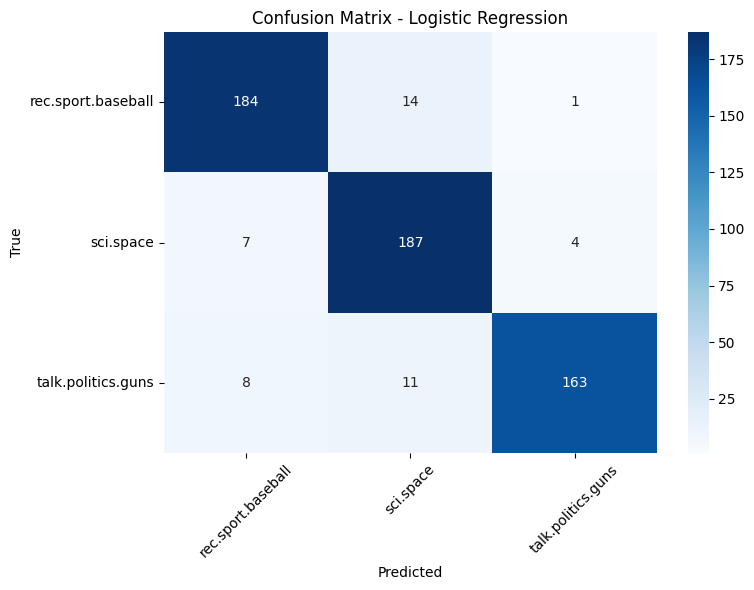

GPU not available. Skipping DistilBERT fine-tuning.
Models saved locally.
Process completed successfully!


In [7]:
# Task 3 — NLP (Sentiment Classification) — Full Colab Notebook

## 1. Setup & Installation
!pip install pandas numpy matplotlib scikit-learn seaborn transformers datasets --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os

print("Setup complete.")

# -------------------------------------------------------------
## 2. Load Dataset - using 20 Newsgroups as sample sentiment dataset
# -------------------------------------------------------------
print("Loading a sample sentiment dataset (20 Newsgroups subset).")

from sklearn.datasets import fetch_20newsgroups

# We'll use 3 categories for demonstration
categories = ['rec.sport.baseball', 'sci.space', 'talk.politics.guns']
newsgroups_train = fetch_20newsgroups(
    subset='train',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)
newsgroups_test = fetch_20newsgroups(
    subset='test',
    categories=categories,
    remove=('headers', 'footers', 'quotes')
)

# Convert integer targets into category names
train_labels = [newsgroups_train.target_names[i] for i in newsgroups_train.target]
test_labels = [newsgroups_test.target_names[i] for i in newsgroups_test.target]

# Build DataFrame
df = pd.DataFrame({
    'text': newsgroups_train.data + newsgroups_test.data,
    'label': train_labels + test_labels
})

print("Sample sentiment dataset loaded. Shape:", df.shape)
print(df.head())

# -------------------------------------------------------------
## 3. Preprocessing — clean labels, group top categories
# -------------------------------------------------------------
df = df[['text', 'label']].dropna()
df['label'] = df['label'].astype(str).str.strip().str.lower()

# Ensure we don’t group beyond available labels
unique_labels = df['label'].nunique()
top_n = min(5, unique_labels)

# Group top-n labels + 'other'
top_labels = df['label'].value_counts().nlargest(top_n).index.tolist()
df['label_grouped'] = df['label'].apply(lambda x: x if x in top_labels else 'other')

print("Label distribution:")
print(df['label_grouped'].value_counts())

# -------------------------------------------------------------
## 4. Train-Test Split & TF-IDF
# -------------------------------------------------------------
X = df['text'].astype(str)
y = df['label_grouped']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

vec = TfidfVectorizer(stop_words='english', max_features=10000)
X_train_t = vec.fit_transform(X_train)
X_test_t = vec.transform(X_test)

print("Vectorization complete. Train shape:", X_train_t.shape)

# -------------------------------------------------------------
## 5. Classical Models
# -------------------------------------------------------------
# MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train_t, y_train)
pred_mnb = mnb.predict(X_test_t)
print("MultinomialNB Accuracy:", accuracy_score(y_test, pred_mnb))
print(classification_report(y_test, pred_mnb))

# Logistic Regression (balanced)
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')
lr.fit(X_train_t, y_train)
pred_lr = lr.predict(X_test_t)
print("LogReg Accuracy:", accuracy_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr))

# -------------------------------------------------------------
## 6. Confusion Matrix for Logistic Regression
# -------------------------------------------------------------
cm = confusion_matrix(y_test, pred_lr, labels=lr.classes_)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Logistic Regression")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
## 7. Optional: Fine-tune DistilBERT (requires GPU)
# -------------------------------------------------------------
import torch
if torch.cuda.is_available():
    print("GPU is available. Proceeding with DistilBERT fine-tuning.")

    from datasets import Dataset
    from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments

    # Sample for faster demo
    sample_size = min(5000, len(df))
    df_small = df.sample(sample_size, random_state=42)

    dataset = Dataset.from_pandas(df_small[['text','label_grouped']])

    # Encode labels
    labels = list(df_small['label_grouped'].unique())
    label2id = {l:i for i,l in enumerate(labels)}
    id2label = {i:l for l,i in label2id.items()}
    dataset = dataset.map(lambda e: {'label_id': [label2id[x] for x in e['label_grouped']]}, batched=True)

    # Tokenization
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    def tokenize(batch):
        return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=256)
    dataset = dataset.map(tokenize, batched=True)

    # Split
    dataset = dataset.train_test_split(test_size=0.2, seed=42)
    train_ds, test_ds = dataset['train'], dataset['test']
    train_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])
    test_ds.set_format(type='torch', columns=['input_ids','attention_mask','label_id'])

    # Model
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id
    )

    # Training args
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir='./logs',
        logging_steps=50,
        load_best_model_at_end=True
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
    )

    trainer.train()
    trainer.evaluate()
else:
    print("GPU not available. Skipping DistilBERT fine-tuning.")

# -------------------------------------------------------------
## 8. Save Models & Vectorizer
# -------------------------------------------------------------
import joblib

joblib.dump(vec, "tfidf_vectorizer.pkl")
joblib.dump(mnb, "model_mnb.pkl")
joblib.dump(lr, "model_logreg.pkl")

print("Models saved locally.")
print("Process completed successfully!")
